<h1 style='text-align:center; margin:30px 0px; text-decoration:underline; text-underline-offset:50px;'>Scene Text Recognition </h1>
<br>

<img src=https://i.ibb.co/VgCCfyM/Screenshot-from-2021-06-29-13-32-15.png>
<div style='text-align:center;'><a href=https://arxiv.org/abs/2105.04286>SOURCE</a></div>
<br><br>

# 1. Business Problem
<br>

## 1.1 Description -
<br>

> __Source:__ https://arxiv.org/abs/2105.04286

<img src=https://i.ibb.co/PFTJPt2/Screenshot-from-2021-06-28-12-40-30.png>

In recent years, there have been increasing demands for scene text recognition in various real-world applications, such as image search, instant translation, and robot navigation. With the emergence of deep learning, there are two main scene text recognition frameworks. 

One is the CRNN framework that encodes images into hidden representations by CNNs and RNNs, and uses the connectionist temporal classification (CTC) for decoding, as shown in Fig. 1 (a). The other is the attention-based encoder-decoder framework that can learn to align output texts with feature maps, as shown in Fig. 1 (b).

However, the above methods still have room for improvement. On the one hand, for CTC-based methods, the extracted feature sequences contain redundant information that may degrade the performance on irregular text images.

On the other hand, attention-based encoder-decoder methods usually suffer from the misalignment problem, because the alignment between feature maps and texts is highly sensitive to previous decoded results, which lack global visual information. Therefore, to handle the diversity of texts in natural scenes, it is important to exploit intrinsic representations of scene text images.
<br><br>

## 1.2 Business Objective -
<br>

Given a cropped image consiting of some text, our objective is to build a system that takes this image as input and predicts the text in the image as output accurately and fastly.
<br><br>


## 1.3 Constraints -
<br>

- The image need not have regular and easily readable text, it can have the text in any orientation, color, shade and even the font style can be different and we can also have numeric text.


- The prediction should be as accurate as possible.


- The prediction should also be fast, given an input image we don't want to wait several minutes or hours to get the prediction. 

    Also, this constraint is more of application dependent, for example if we are working with self-driving cars or robots or automatic checkouts then we must have very low latency, on the other hand if we are working on a task which is not very urgent then it is acceptable even if we get the prediction in some time.
<br><br>

# 2. Machine Learning Problem
<br>

## 2.1 Data
<br>

We will be using the mjsynth dataset which is a synthetic word dataset having images of words in different styles, shades and fonts.

<b>Sample -</b>

<br>

<img src=https://www.robots.ox.ac.uk/~vgg/data/text/synthflow.png>

<br>

To know more about the dataset and download the zipped file - <a href=https://www.robots.ox.ac.uk/~vgg/data/text/><b>Visit Here</b></a>.

<br>

After Extracting the mjsynth.tar.gz file we get the mjsynth folder with the following directory structure,

1. All the Files are present in the __'mjsynth/mnt/ramdisk/max/90kDICT32px'__ directory.


2. The directory has folders from 1 to 4000 out of which folders from 3001 and 4000 are empty.


3. We have 5 text files also in the same directory out of which the 3 important ones are __'annotation_train.txt'__, __'annotation_val.txt'__ and __'annotation_test.txt'__ each of which corresponding to the files of train, validation and test datasets respectively.


4. The word present in the image is present in the file name itself surrounded by \_. For example, for an Image havign word __play__ has its name in the following format __\*\_play\_\*__, where \* corresponds to some text.  
<br><br>

### Citation 
<br>

<pre>
@InProceedings{Jaderberg14c,
  author       = "Max Jaderberg and Karen Simonyan and Andrea Vedaldi and Andrew Zisserman",
  title        = "Synthetic Data and Artificial Neural Networks for Natural Scene Text Recognition",
  booktitle    = "Workshop on Deep Learning, NIPS",
  year         = "2014",
}


@Article{Jaderberg16,
  author       = "Max Jaderberg and Karen Simonyan and Andrea Vedaldi and Andrew Zisserman",
  title        = "Reading Text in the Wild with Convolutional Neural Networks",
  journal      = "International Journal of Computer Vision",
  number       = "1",
  volume       = "116",
  pages        = "1--20",
  month        = "jan",
  year         = "2016",
}
</pre>
<br><br>

## 2.2 Performance Metric and Loss Function-
<br>

- __Performance Metric -__ Since, we already have the ground truth labels and our model will be making predictions for the same label. Hence, word accuracy and letter accuracy can be used to measure the performance of the model.


- __Loss Function -__ We will be using Cross Entropy Loss between the ground truth label and the predicted label as the loss function.
<br><br>

# 3. EDA -
<br>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation
<br>

In [2]:
dir_path = 'mjsynth/mnt/ramdisk/max/90kDICT32px'

In [3]:
# Reading each of the annotation file to fetch the train, validation and test datasets separately

train = pd.read_csv(dir_path+'/annotation_train.txt', header = None)
validation = pd.read_csv(dir_path+'/annotation_val.txt', header = None)
test = pd.read_csv(dir_path+'/annotation_test.txt', header = None)

In [4]:
print("*"*40)
print("\nOriginal Train Dataset Size : {}".format(train.shape[0]))
print("Original Validation Dataset Size : {}".format(validation.shape[0]))
print("Original Test Dataset Size : {}\n".format(test.shape[0]))
print("*"*40)

****************************************

Original Train Dataset Size : 7224612
Original Validation Dataset Size : 802734
Original Test Dataset Size : 891927

****************************************


In [5]:
train.head()

,0
0,./2425/1/115_Lube_45484.jpg 45484
1,./2425/1/114_Spencerian_73323.jpg 73323
2,./2425/1/113_accommodatingly_613.jpg 613
3,./2425/1/112_CARPENTER_11682.jpg 11682
4,./2425/1/111_REGURGITATING_64100.jpg 64100


In [6]:
# Making the relative paths absolute

train[0] = [dir_path+value.split()[0][1:] for value in train[0].values]
validation[0] = [dir_path+value.split()[0][1:] for value in validation[0].values]
test[0] = [dir_path+value.split()[0][1:] for value in test[0].values]

In [7]:
# Naming the Column as "path"

train = train.rename(columns={0:"path"})
validation = validation.rename(columns={0:"path"})
test = test.rename(columns={0:"path"})

In [8]:
train.head()

,path
0,mjsynth/mnt/ramdisk/max/90kDICT32px/2425/1/115...
1,mjsynth/mnt/ramdisk/max/90kDICT32px/2425/1/114...
2,mjsynth/mnt/ramdisk/max/90kDICT32px/2425/1/113...
3,mjsynth/mnt/ramdisk/max/90kDICT32px/2425/1/112...
4,mjsynth/mnt/ramdisk/max/90kDICT32px/2425/1/111...


In [9]:
# Creating the Directories 

! mkdir Data
! mkdir Data/train
! mkdir Data/validation
! mkdir Data/test

In [10]:
# Moving the files corresponding to train, validation and test from mjsynth directory to train, val and test directories of Data directory

for path in tqdm(train['path'].values):
    os.rename(path, 'Data/train/'+path.split('/')[-1])
    
for path in tqdm(validation['path'].values):
    os.rename(path, 'Data/validation/'+path.split('/')[-1])
    
for path in tqdm(test['path'].values):
    os.rename(path, 'Data/test/'+path.split('/')[-1])

100%|██████████| 891927/891927 [00:12<00:00, 70390.40it/s]


In [11]:
# Removing the mjsynth directory

! rm -rf mjsynth/

In [12]:
# Deleting the train, val and test files corresponding to files of mjsynth Directory

del train, validation, test

In [13]:
# Creating new train, val and test files hvaing path of files in train, val and test of Data Directory and also fetching the label from the file names

train = pd.DataFrame({"path":['Data/train/'+file for file in os.listdir('Data/train')], 'label':[file.split('_')[1].upper() for file in os.listdir('Data/train')]})
validation = pd.DataFrame({"path":['Data/validation/'+file for file in os.listdir('Data/validation')], 'label':[file.split('_')[1].upper() for file in os.listdir('Data/validation')]})
test = pd.DataFrame({"path":['Data/test/'+file for file in os.listdir('Data/test')], 'label':[file.split('_')[1].upper() for file in os.listdir('Data/test')]})

In [14]:
train.head()

,path,label
0,Data/train/269_Ascii_4206.jpg,ASCII
1,Data/train/230_Polyethylene_58675.jpg,POLYETHYLENE
2,Data/train/442_sordidness_72826.jpg,SORDIDNESS
3,Data/train/225_warhol_85462.jpg,WARHOL
4,Data/train/476_PREOCCUPY_59726.jpg,PREOCCUPY


In [15]:
# Checking the Validity of all the images in each of the three sets and removing the invalid images

train_invalids = []
validation_invalids = []
test_invalids = []

for idx, path in enumerate(tqdm(train.path)):
    try:
        Image.open(path).verify()
        
        img = cv2.imread(path)
        if type(img) != np.ndarray:
            os.remove(path)
            train_invalids.append(idx)
    except:
        os.remove(path)
        train_invalids.append(idx)
        
        
for idx, path in enumerate(tqdm(validation.path)):
    try:
        Image.open(path).verify()
        
        img = cv2.imread(path)
        if type(img) != np.ndarray:
            os.remove(path)
            validation_invalids.append(idx)
    except:
        os.remove(path)
        validation_invalids.append(idx)
            
        
for idx, path in enumerate(tqdm(test.path)):
    try:
        Image.open(path).verify()
        
        img = cv2.imread(path)
        if type(img) != np.ndarray:
            os.remove(path)
            test_invalids.append(idx)
    except:
        os.remove(path)
        test_invalids.append(idx)
        
        
train.drop(list(set(train_invalids)), inplace=True)
validation.drop(list(set(validation_invalids)), inplace=True)
test.drop(list(set(test_invalids)), inplace=True)

100%|██████████| 888835/888835 [03:57<00:00, 3745.67it/s]


In [16]:
# Sample Datapoint

sample_img = Image.open(train.path[6])
print("Label : {}".format(train.label[6]))
sample_img

Label : SOLIDNESS


In [17]:
train.reset_index(drop=True).to_csv('Data/train.csv', index=False)
validation.reset_index(drop=True).to_csv('Data/validation.csv', index=False)
test.reset_index(drop=True).to_csv('Data/test.csv', index=False)

## Analysing Missing Values
<br>

In [2]:
train = pd.read_csv('Data/train.csv')
validation = pd.read_csv('Data/validation.csv')
test = pd.read_csv('Data/test.csv')

In [3]:
# Checking for missing values

train.isna().sum()

path       0
label    155
dtype: int64

In [4]:
# Rows with missing value in Train Data

train[train.label.isna()]

,path,label
27384,Data/train/122_NULL_52538.jpg,NaN
94101,Data/train/261_null_52538.jpg,NaN
103710,Data/train/26_NA_50735.jpg,NaN
117356,Data/train/112_NA_50735.jpg,NaN
151732,Data/train/245_Null_52538.jpg,NaN
...,...,...
6792639,Data/train/150_na_50735.jpg,NaN
6858901,Data/train/47_na_50735.jpg,NaN
6876761,Data/train/493_null_52538.jpg,NaN
6884163,Data/train/15_na_50735.jpg,NaN


In [5]:
img = Image.open(train.path[27384])
img

__Observation(s)__:

From the missing value analysis, it is found that in reality we do not have missing values instead the label itself is "nan" and pandas due to its default implementation has considered it as missing values but in reality there is no missing value. So, in order to avoid this confusion we will be explicitly telling pandas to not filter "nan" values while reading the csv.
<br><br>

In [6]:
train = pd.read_csv('Data/train.csv', na_filter=False)
validation = pd.read_csv('Data/validation.csv', na_filter=False)
test = pd.read_csv('Data/test.csv', na_filter=False)

In [7]:
train.isna().sum()

path     0
label    0
dtype: int64

In [8]:
validation.isna().sum()

path     0
label    0
dtype: int64

In [9]:
test.isna().sum()

path     0
label    0
dtype: int64

## Analysing the Length of the Labels
<br>

In [10]:
# Analysing the Length of Labels

train_labels_len = [len(str(l)) for l in tqdm(train.label)]
validation_labels_len = [len(str(l)) for l in tqdm(validation.label)]
test_labels_len = [len(str(l)) for l in tqdm(test.label)]

100%|██████████| 888832/888832 [00:00<00:00, 2630993.96it/s]


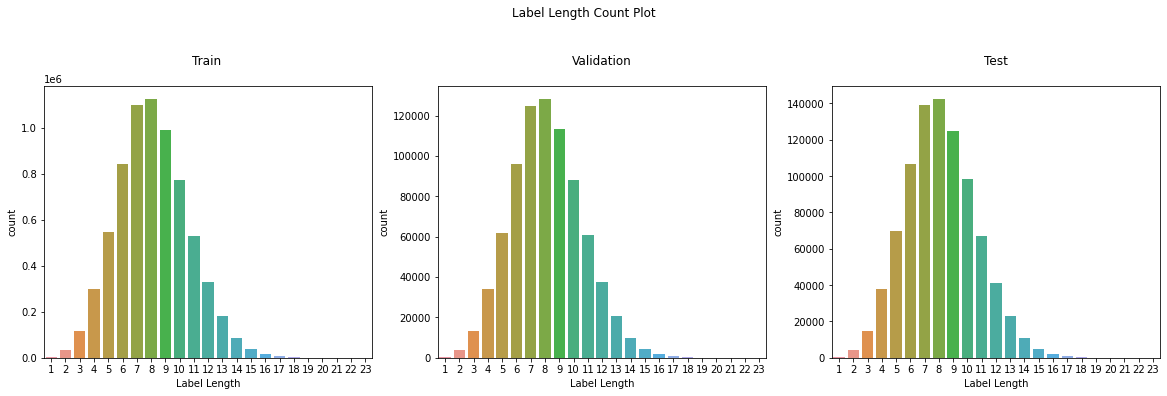

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Label Length Count Plot', y=1.1)

sns.countplot(x = train_labels_len, ax=ax[0])
ax[0].set_title("\nTrain \n")
ax[0].set_xlabel('Label Length')

sns.countplot(x = validation_labels_len, ax=ax[1])
ax[1].set_title("\nValidation\n")
ax[1].set_xlabel('Label Length')

sns.countplot(x = test_labels_len, ax=ax[2])
ax[2].set_title("\nTest\n")
ax[2].set_xlabel('Label Length')

plt.show()

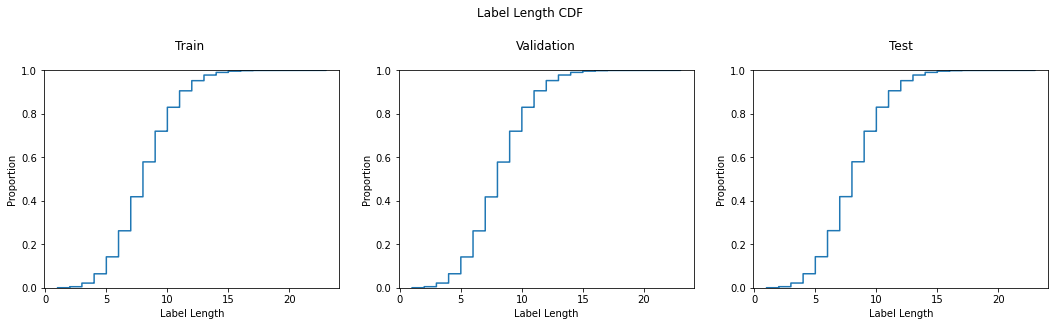

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(18,4))
fig.suptitle('Label Length CDF', y=1.1)

sns.ecdfplot(x = train_labels_len, ax=ax[0])
ax[0].set_title("\nTrain \n")
ax[0].set_xlabel('Label Length')

sns.ecdfplot(x = validation_labels_len, ax=ax[1])
ax[1].set_title("\nValidation\n")
ax[1].set_xlabel('Label Length')

sns.ecdfplot(x = test_labels_len, ax=ax[2])
ax[2].set_title("\nTest\n")
ax[2].set_xlabel('Label Length')

plt.show()

__Observation(s):__ 

From the above plot following Inferences can be made,

1. The longest label length is 23.


2. Almost 99% of the labels have a length of less than or equal to 15.
<br><br>

## Analysing Numeric Labels 
<br>

In [13]:
train_num_labels = []
train_non_num_labels = []

for idx,l in enumerate(tqdm(train.label)):
    if(l.isnumeric()):
        train_num_labels.append(idx)
    else:
        train_non_num_labels.append(idx)
        
validation_num_labels = []
validation_non_num_labels = []

for idx,l in enumerate(tqdm(validation.label)):
    if(l.isnumeric()):
        validation_num_labels.append(idx)
    else:
        validation_non_num_labels.append(idx)
        
test_num_labels = []
test_non_num_labels = []

for idx,l in enumerate(tqdm(test.label)):
    if(l.isnumeric()):
        test_num_labels.append(idx)
    else:
        test_non_num_labels.append(idx)

100%|██████████| 888832/888832 [00:00<00:00, 2395485.38it/s]


In [14]:
print("*"*60)
print("\nTotal Number of Numeric Labels in Train Dataset : {}".format(len(train_num_labels)))
print("Total Number of Non-Numeric Labels in Train Dataset : {}\n".format(len(train_non_num_labels)))
print("\nTotal Number of Numeric Labels in Validation Dataset : {}".format(len(validation_num_labels)))
print("Total Number of Non-Numeric Labels in Validation Dataset : {}\n".format(len(validation_non_num_labels)))
print("\nTotal Number of Numeric Labels in Test Dataset : {}".format(len(test_num_labels)))
print("Total Number of Non-Numeric Labels in Test Dataset : {}\n".format(len(test_non_num_labels)))
print("*"*60)

************************************************************

Total Number of Numeric Labels in Train Dataset : 9272
Total Number of Non-Numeric Labels in Train Dataset : 7020558


Total Number of Numeric Labels in Validation Dataset : 1106
Total Number of Non-Numeric Labels in Validation Dataset : 799181


Total Number of Numeric Labels in Test Dataset : 1271
Total Number of Non-Numeric Labels in Test Dataset : 887561

************************************************************


In [15]:
# Rows with Numeric Labels in Train Set

train.iloc[train_num_labels]

,path,label
388,Data/train/346_2_49.jpg,2
909,Data/train/68_250_69.jpg,250
1128,Data/train/271_002101_2.jpg,002101
1643,Data/train/448_511_108.jpg,511
3259,Data/train/408_311_81.jpg,311
...,...,...
7026873,Data/train/355_358_88.jpg,358
7027200,Data/train/26_80_138.jpg,80
7027960,Data/train/64_01206368166_5.jpg,01206368166
7028617,Data/train/343_439_96.jpg,439


In [16]:
# Sample Image with Numeric Label in Train Set

num_img = Image.open(train.path[1128])
num_img

## Analysing the Image Dimensions
<br>

In [17]:
heights_train = []
widths_train = []

for file in tqdm(train.path):
    width, height = Image.open(file).size
    widths_train.append(width)
    heights_train.append(height)        

heights_validation = []
widths_validation = []

for file in tqdm(validation.path):
    width, height = Image.open(file).size
    widths_validation.append(width)
    heights_validation.append(height)        

heights_test = []
widths_test = []

for file in tqdm(test.path):
    width, height = Image.open(file).size
    widths_test.append(width)
    heights_test.append(height)        

100%|██████████| 888832/888832 [01:39<00:00, 8969.67it/s] 


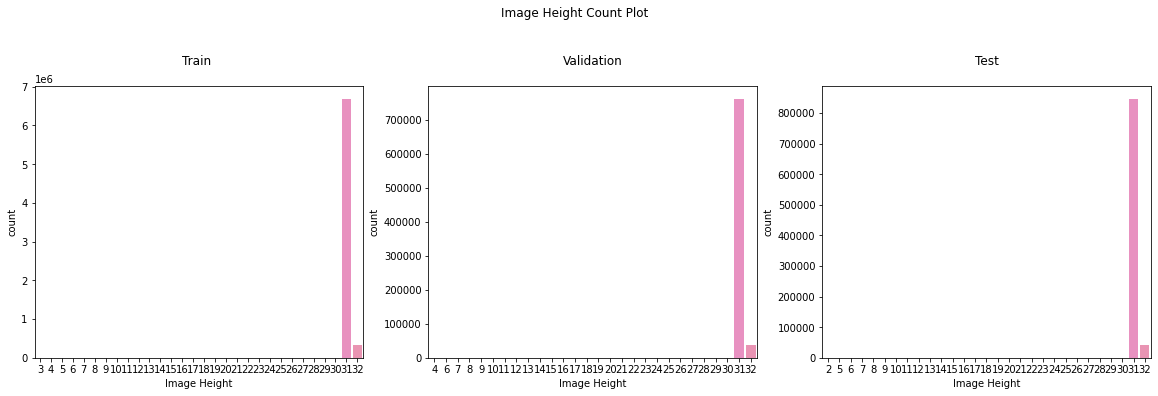

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Image Height Count Plot', y=1.1)

sns.countplot(x = heights_train, ax=ax[0])
ax[0].set_title("\nTrain \n")
ax[0].set_xlabel('Image Height')

sns.countplot(x = heights_validation, ax=ax[1])
ax[1].set_title("\nValidation\n")
ax[1].set_xlabel('Image Height')

sns.countplot(x = heights_test, ax=ax[2])
ax[2].set_title("\nTest\n")
ax[2].set_xlabel('Image Height')

plt.show()

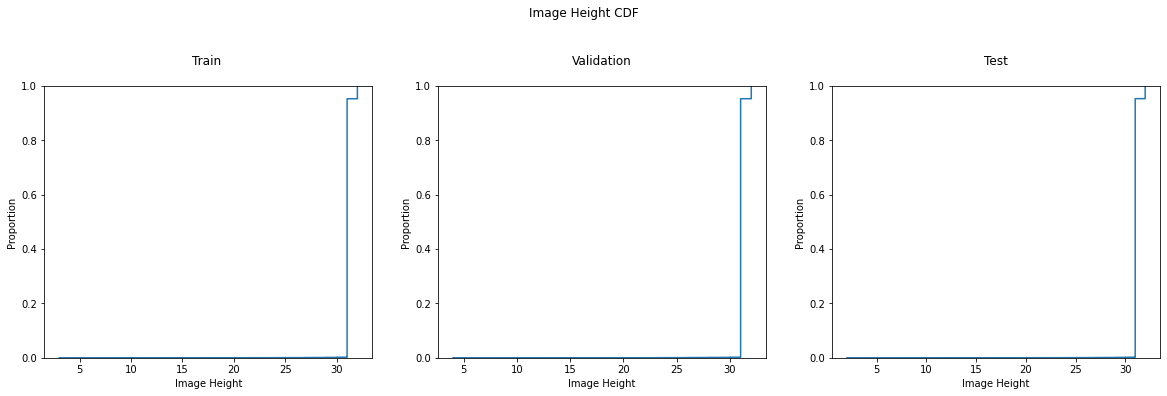

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Image Height CDF', y=1.1)

sns.ecdfplot(x = heights_train, ax=ax[0])
ax[0].set_title("\nTrain \n")
ax[0].set_xlabel('Image Height')

sns.ecdfplot(x = heights_validation, ax=ax[1])
ax[1].set_title("\nValidation\n")
ax[1].set_xlabel('Image Height')

sns.ecdfplot(x = heights_test, ax=ax[2])
ax[2].set_title("\nTest\n")
ax[2].set_xlabel('Image Height')

plt.show()

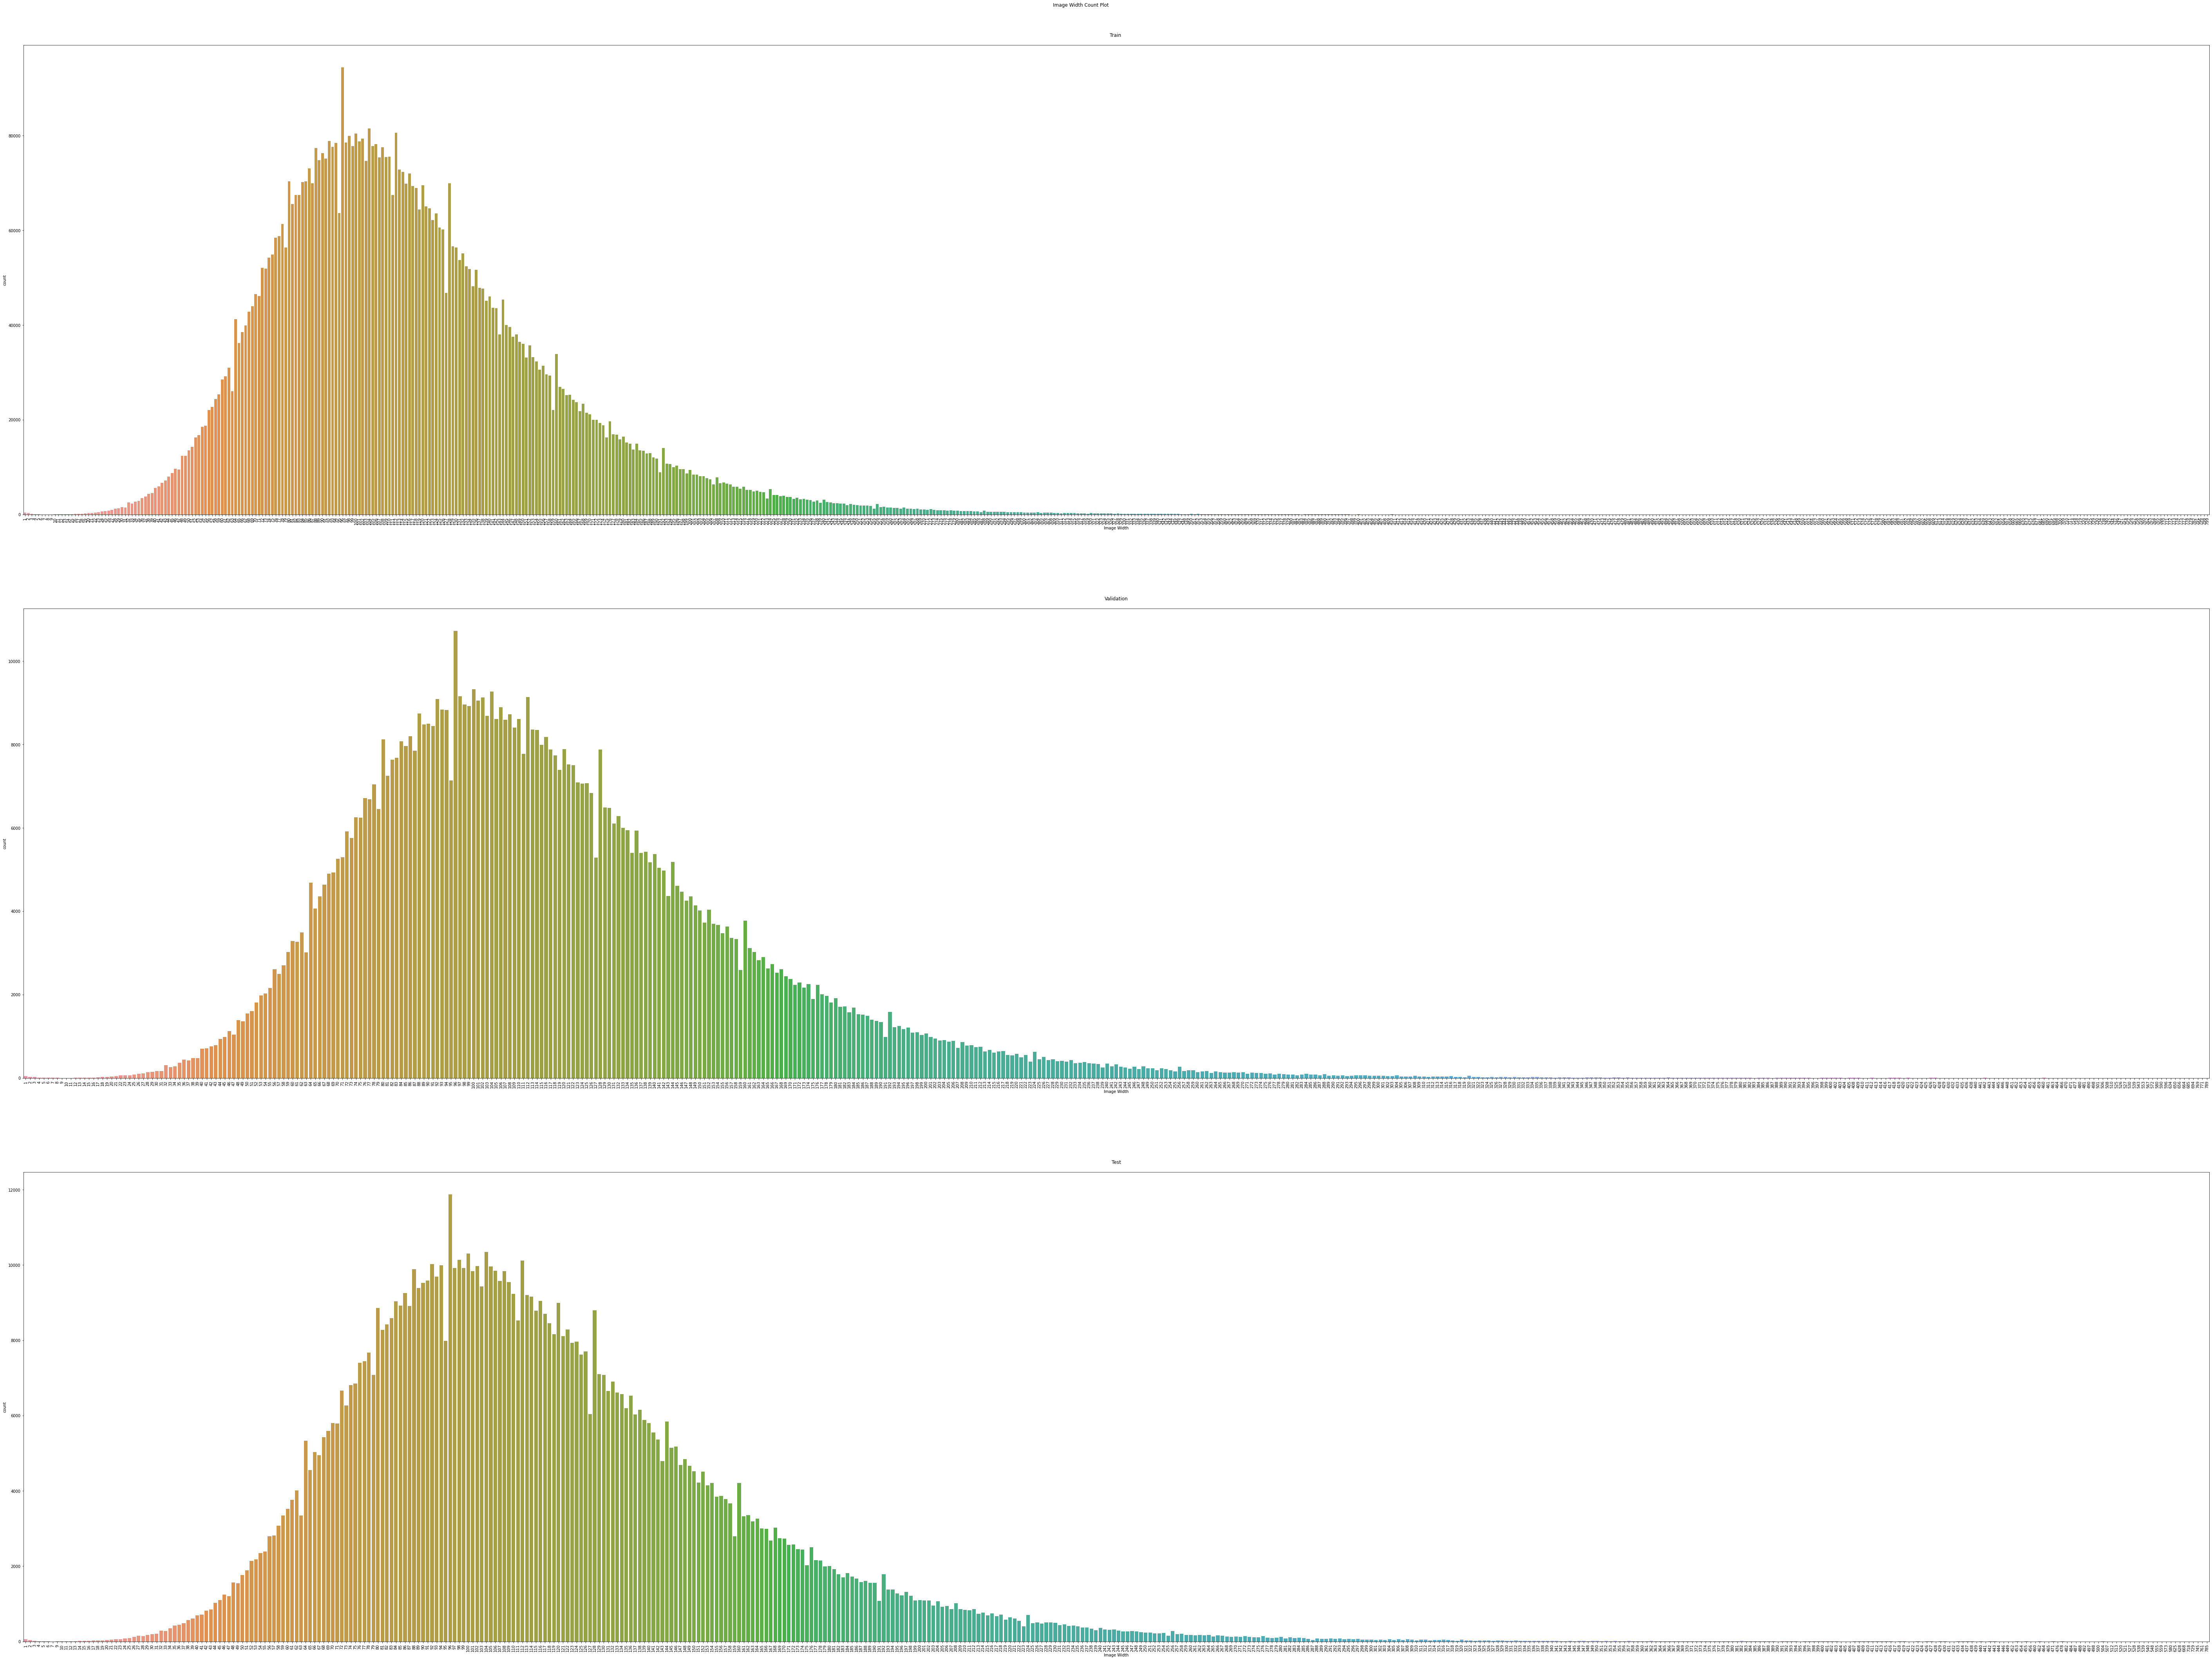

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(100, 75))
fig.suptitle('Image Width Count Plot', y=0.9)

sns.countplot(x = widths_train, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90, ha='center')
ax[0].set_title("\nTrain \n")
ax[0].set_xlabel('Image Width')

sns.countplot(x = widths_validation, ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90, ha='center')
ax[1].set_title("\nValidation\n")
ax[1].set_xlabel('Image Width')

sns.countplot(x = widths_test, ax=ax[2])
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=90, ha='center')
ax[2].set_title("\nTest\n")
ax[2].set_xlabel('Image Width')

plt.show()

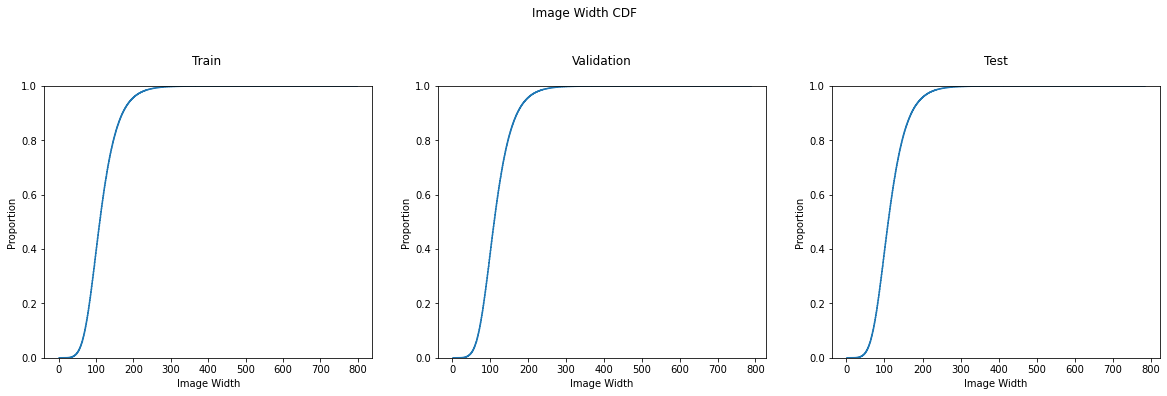

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Image Width CDF', y=1.1)

sns.ecdfplot(x = widths_train, ax=ax[0])
ax[0].set_title("\nTrain \n")
ax[0].set_xlabel('Image Width')

sns.ecdfplot(x = widths_validation, ax=ax[1])
ax[1].set_title("\nValidation\n")
ax[1].set_xlabel('Image Width')

sns.ecdfplot(x = widths_test, ax=ax[2])
ax[2].set_title("\nTest\n")
ax[2].set_xlabel('Image Width')

plt.show()

__Observation(s):__

Following Inferences can be made from the above plots,

1. Images have height ranging between 2 and 32.


2. Almost 99% of the Images have a height of 31.


3. Image Width varies between 1 and 799.


4. Majority of the Images have a width between 30 and 190.
<br><br>

## Sampling Dataset
<br>

The sampling will be performed as follows,

- Very small images will not be considered in the sampled dataset.


- 3 lakh images from the original train dataset will be sampled.


- 1.2 lakh images will be sampled from the original validation dataset.


- 80 thousand images will be sampled from the original test dataset.
<br><br>

In [22]:
drop_images_train = []
drop_images_validation = []
drop_images_test = []

In [23]:
# Dropping very small images having heights less than 5

drop_based_on_height_train = [idx for idx, h in enumerate(heights_train) if h<5]
drop_based_on_height_validation = [idx for idx, h in enumerate(heights_validation) if h<5]
drop_based_on_height_test = [idx for idx, h in enumerate(heights_test) if h<5]

drop_images_train+=drop_based_on_height_train
drop_images_validation+=drop_based_on_height_validation
drop_images_test+=drop_based_on_height_test

In [24]:
# Dropping all the images having width less than 5

drop_based_on_width_train = [idx for idx, w in enumerate(widths_train) if w<5]
drop_based_on_width_validation = [idx for idx, w in enumerate(widths_validation) if w<5]
drop_based_on_width_test = [idx for idx, w in enumerate(widths_test) if w<5]

drop_images_train+=drop_based_on_width_train
drop_images_validation+=drop_based_on_width_validation
drop_images_test+=drop_based_on_width_test

In [25]:
print("*"*45)
print("\nTrain images to be dropped : ", len(set(drop_images_train)))
print("Valdiation images to be dropped : ", len(set(drop_images_validation)))
print("Test images to be dropped : ", len(set(drop_images_test)), "\n")
print("*"*45)

*********************************************

Train images to be dropped :  933
Valdiation images to be dropped :  99
Test images to be dropped :  114 

*********************************************


In [26]:
train.drop(set(drop_images_train), inplace=True)
validation.drop(set(drop_images_validation), inplace=True)
test.drop(set(drop_images_test), inplace=True)

In [27]:
# Sampling the datasets

train = train.sample(300000, random_state=3).reset_index(drop=True)
validation = validation.sample(120000, random_state=3).reset_index(drop=True)
test = test.sample(80000, random_state=3).reset_index(drop=True)

In [28]:
train.head()

,path,label
0,Data/train/456_Epidemic_26190.jpg,EPIDEMIC
1,Data/train/288_quiche_61844.jpg,QUICHE
2,Data/train/458_deescalates_19943.jpg,DEESCALATES
3,Data/train/330_thermos_78597.jpg,THERMOS
4,Data/train/329_megatons_47589.jpg,MEGATONS


In [29]:
print("*"*40)
print("\nSampled Train Dataset Size : {}".format(train.shape[0]))
print("Sampled Validation Dataset Size : {}".format(validation.shape[0]))
print("Sampled Test Dataset Size : {}\n".format(test.shape[0]))
print("*"*40)

****************************************

Sampled Train Dataset Size : 300000
Sampled Validation Dataset Size : 120000
Sampled Test Dataset Size : 80000

****************************************


In [30]:
# Removing the remaining files

train_files = set(['Data/train/'+file for file in list(os.listdir('Data/train'))])
validation_files = set(['Data/validation/'+file for file in list(os.listdir('Data/validation'))])
test_files = set(['Data/test/'+file for file in list(os.listdir('Data/test'))])

sampled_train_files = set(train['path'].values)
sampled_validation_files = set(validation['path'].values)
sampled_test_files = set(test['path'].values)

remove_train = train_files - sampled_train_files
remove_validation = validation_files - sampled_validation_files
remove_test = test_files - sampled_test_files

for file in tqdm(remove_train):
    os.remove(file)
    
for file in tqdm(remove_validation):
    os.remove(file)
    
for file in tqdm(remove_test):
    os.remove(file)

100%|██████████| 808832/808832 [00:15<00:00, 52567.57it/s]


In [31]:
train.reset_index(drop=True).to_csv('Data/train.csv', index=False)
validation.reset_index(drop=True).to_csv('Data/validation.csv', index=False)
test.reset_index(drop=True).to_csv('Data/test.csv', index=False)